In [1]:
import pandas as pd
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.font_manager as fm
from tqdm import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
meta_file = pd.read_csv('./LJSpeech-1.1/metadata.csv', header = None, error_bad_lines=False)

b'Skipping line 7: expected 5 fields, saw 7\nSkipping line 9: expected 5 fields, saw 7\nSkipping line 12: expected 5 fields, saw 9\nSkipping line 22: expected 5 fields, saw 7\nSkipping line 25: expected 5 fields, saw 7\nSkipping line 27: expected 5 fields, saw 7\nSkipping line 28: expected 5 fields, saw 9\nSkipping line 30: expected 5 fields, saw 7\nSkipping line 35: expected 5 fields, saw 7\nSkipping line 45: expected 5 fields, saw 7\nSkipping line 53: expected 5 fields, saw 7\nSkipping line 56: expected 5 fields, saw 7\nSkipping line 58: expected 5 fields, saw 9\nSkipping line 59: expected 5 fields, saw 7\nSkipping line 70: expected 5 fields, saw 9\nSkipping line 76: expected 5 fields, saw 13\nSkipping line 84: expected 5 fields, saw 7\nSkipping line 86: expected 5 fields, saw 11\nSkipping line 87: expected 5 fields, saw 7\nSkipping line 93: expected 5 fields, saw 7\nSkipping line 99: expected 5 fields, saw 9\nSkipping line 111: expected 5 fields, saw 9\nSkipping line 118: expected 5

In [3]:
file_name, text = [], []

for i in tqdm(range(len(meta_file))):
    line = meta_file.iloc[i,:].to_list()
    string = ''.join([term for term in line if type(term) == str]).split('|')
    file_name.append( './LJSpeech-1.1/wavs/{}.wav'.format(string[0]))
    text.append([string[1]])

100%|██████████| 8751/8751 [00:01<00:00, 6577.65it/s]


In [4]:
print(file_name[:10])

['./LJSpeech-1.1/wavs/LJ001-0001.wav', './LJSpeech-1.1/wavs/LJ001-0002.wav', './LJSpeech-1.1/wavs/LJ001-0003.wav', './LJSpeech-1.1/wavs/LJ001-0004.wav', './LJSpeech-1.1/wavs/LJ001-0005.wav', './LJSpeech-1.1/wavs/LJ001-0006.wav', './LJSpeech-1.1/wavs/LJ001-0008.wav', './LJSpeech-1.1/wavs/LJ001-0010.wav', './LJSpeech-1.1/wavs/LJ001-0011.wav', './LJSpeech-1.1/wavs/LJ001-0013.wav']


In [5]:
text[:10]

[['Printing in the only sense with which we are at present concerned differs from most if not from all the arts and crafts represented in the Exhibition'],
 ['in being comparatively modern.'],
 ['For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands by a similar process'],
 ['produced the block books which were the immediate predecessors of the true printed book'],
 ['the invention of movable metal letters in the middle of the fifteenth century may justly be considered as the invention of the art of printing.'],
 ['And it is worth mention in passing that as an example of fine typography'],
 ['has never been surpassed.'],
 ['Now as all books not primarily intended as picture-books consist principally of types composed to form letterpress'],
 ['it is of the first importance that the letter used should be fine in form;'],
 ['than in the same operations with ugly ones.']]

In [6]:
def preprocess_wav(file_name, stft_frame_size, hop_size, mel_filter_size, f_min = 0.0, f_max = None):
    '''
    stft_frame_size, hop_size unit is mili seconds
    '''
    wav, sample_rate  = librosa.load(file_name)
    
    milisec_per_frame = sample_rate * 1e-3
    n_fft = int(milisec_per_frame * stft_frame_size)
    hop_length = int(milisec_per_frame * hop_size)
    win_length = int(milisec_per_frame * stft_frame_size)
    
    stft = librosa.core.stft(wav, n_fft = n_fft, hop_length = hop_length, win_length = win_length)
    stft = np.abs(stft)
    mel_filters = librosa.filters.mel(sr = sample_rate, 
                                      n_fft = n_fft,
                                      n_mels = mel_filter_size,
                                      fmin = f_min,
                                      fmax = f_max)
    mel_output = np.dot(mel_filters, stft)
    return mel_output, sample_rate

In [7]:
stft_frame_size = 50
hop_size = 12.5
mel_filter_size = 80
f_min = 125
f_max = 7.6 * 1e3

In [8]:
def show_spectrogram(mel, sample_rate):
    log_S = librosa.power_to_db(mel, ref = np.max)
    plt.figure(figsize = (12,4))
    librosa.display.specshow(log_S, sr = sample_rate, x_axis = 'time', y_axis = 'mel')
    plt.tight_layout()
    plt.colorbar(format = '%+02.0f db')

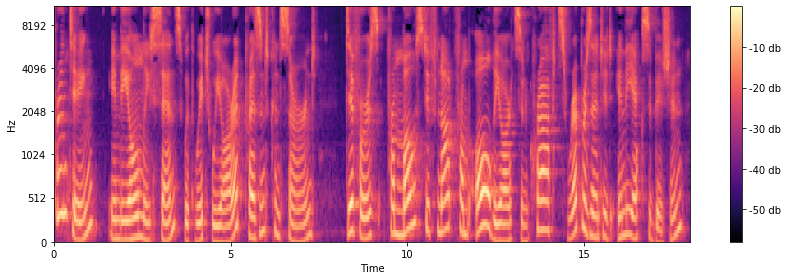

In [9]:
mel_spectrogram, sample_rate = preprocess_wav(file_name[0], stft_frame_size, hop_size, mel_filter_size, f_min, f_max)
show_spectrogram(mel_spectrogram, sample_rate)

In [10]:
vocab = set()
char_text =  []
max_sequence_length = 0
for sentence in tqdm(text):
    char_list = [char for char in sentence[0].strip()]
    char_text += char_list
    vocab.update(char_list)
    max_sequence_length = max_sequence_length if max_sequence_length > len(char_list) else len(char_list)
vocab = ['<p>', '<start>', '<end>'] + list(vocab)
token_to_ids = {char:i for i, char in enumerate(vocab)}
char_text = [[token_to_ids['<start>']] + [token_to_ids[char] for char in sentence] + [token_to_ids['<end>']] for sentence in char_text]

100%|██████████| 8751/8751 [00:00<00:00, 157089.84it/s]


In [11]:
print('vocab size : {}'.format(len(vocab)))
print('maximum length of text : {}'.format(max_sequence_length))
char_text = pad_sequences(char_text, maxlen = max_sequence_length, padding = 'post')

vocab size : 90
maximum length of text : 187


In [12]:
mel_list = []
max_mel_length = 0
for fn  in tqdm(file_name):
    mel, _ = preprocess_wav(fn, stft_frame_size, hop_size, mel_filter_size, f_min, f_max)
    mel_list.append(mel)
    max_mel_length = max_mel_length if max_mel_length > mel.shape[1] else mel.shape[1]

100%|██████████| 8751/8751 [03:40<00:00, 39.64it/s]


In [17]:
print(mel.shape)
pad_value = ((0,0),(max_mel_length - mel.shape[1], 0))
print(np.pad(mel, pad_value, mode = 'constant', constant_values = 0).shape)
pad_mel = []
gate_value = []
for i in tqdm(range(len(mel_list))):
    pad_value = ((0,0),(max_mel_length - mel_list[i].shape[1], 0))
    one = np.ones((max_mel_length))
    one[mel_list[i].shape[1]-1] = 1
    gate_value.append(one)
    pad_mel.append(np.pad(mel_list[i], pad_value, mode = 'constant', constant_values = 0))

 16%|█▌        | 1365/8751 [00:00<00:01, 6817.67it/s]

(80, 716)
(80, 810)


100%|██████████| 8751/8751 [00:03<00:00, 2638.09it/s]


In [20]:
import pickle as pkl

for fn, mel_output, text, gate in zip(file_name, pad_mel, char_text, gate_value):
    f_name = fn.split('/')[-1][:-4]
    with open('./text/{}.pkl'.format(f_name), 'wb') as f:
        pkl.dump(text, f)
    with open('./wav/{}.pkl'.format(f_name), 'wb') as f:
        pkl.dump(mel_output, f)
    with open('./gate/{}.pkl'.format(f_name), 'wb') as f:
        pkl.dump(gate, f)
        
with open('./vocab.pkl', 'wb') as f:
    pkl.dump(vocab, f)

In [15]:
file_name[0]

'./LJSpeech-1.1/wavs/LJ001-0001.wav'